# Using LSTM for Cryptocurrency price prediction 

## Samyakh Tukra

Dataset attained from: https://coinmarketcap.com/

The Kaggle version of the dataset in csv format: https://www.kaggle.com/mczielinski/bitcoin-historical-data

Brief description of data:
Usually in RNNs the data is 3 dimensional i.e. [data_examples (i.e. samples), valued_per_time_step (i.e. inputs),time_steps( the sequence length)]

Usually for stock prediction, there are 5 features present: open, close, low, high and volume price. The goal is to predict the future price i.e. the future 'close' price. Hence, the input vector_size = 5.

Generally; stock prices are a time series of N length, and I need to feed in the data using a sliding window of fixed size w, everytime I move the window to the right by size w (to prevent overlap)

Additionally, I will have to normalise the data, since stock indexes increases in time, and the thus the data in train will not be the sme as the test which negates the generalisation! i.e. most values in test set are likely to be out of the scale of the train set and thus model has to predict numbers it has never seen before! this will result in a poor prediction... therefore to sove the out of scale issue, I normalise the prices in each sliding window and the task becomed predicting the relative change rates instead of the absolute values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import lxml
import html5lib

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout



d:\program files\python354\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# get the market data for bitcoin in particular (or any other cryptocurrency of choice)
start_date = '20180210'
end_date = '20180312'
bitcoin_market_history = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + start_date + "&end=" + end_date)[0]

# actual html: https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180210&end=20180312

# convert the date string to the correct date format
bitcoin_market_history = bitcoin_market_history.assign(Date=pd.to_datetime(bitcoin_market_history['Date']))

# convert The raw values from string to integers
bitcoin_market_history['Volume'] = bitcoin_market_history['Volume'].astype('int64')

# Visualise the first 5 rows:
bitcoin_market_history.head()

# Note: I can also import data from the CSV file!

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-10,9350.59,9531.32,8828.47,8866.00,5386320000,158119000000
1,2018-03-09,9414.69,9466.35,8513.03,9337.55,8704190000,159185000000
2,2018-03-08,9951.44,10147.40,9335.87,9395.01,7186090000,168241000000
3,2018-03-07,10803.90,10929.50,9692.12,9965.57,8797910000,182631000000
4,2018-03-06,11500.10,11500.10,10694.30,10779.90,6832170000,194378000000


In [6]:
# also visualise the bottom few rows to get the last date:
bitcoin_market_history.tail()
# Hence only using data for the last 30 days

,Date,Open,High,Low,Close,Volume,Market Cap
24,2018-02-14,8599.92,9518.54,8599.92,9494.63,7909820000,145023000000
25,2018-02-13,8926.72,8958.47,8455.41,8598.31,5696720000,150516000000
26,2018-02-12,8141.43,8985.92,8141.43,8926.57,6256440000,137258000000
27,2018-02-11,8616.13,8616.13,7931.10,8129.97,6122190000,145245000000
28,2018-02-10,8720.08,9122.55,8295.47,8621.90,7780960000,146981000000


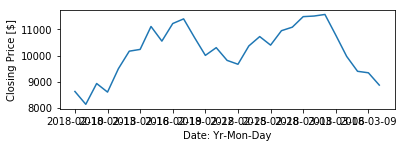

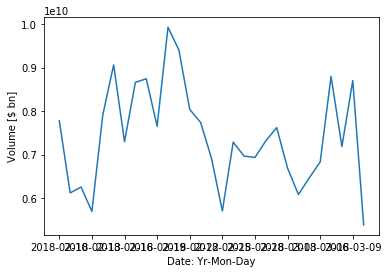

In [12]:
#Visualise plots:
figure_1=plt.figure("Bitcoin Closing price over time")
subplot_1= figure_1.add_subplot(2,1,1)
plt.plot(bitcoin_market_history['Date'],bitcoin_market_history['Close'])
plt.xlabel('Date: Yr-Mon-Day')
plt.ylabel('Closing Price [$]')
plt.show()

figure_2= plt.figure("Bitcoin Volume Sold over time")
plt.plot(bitcoin_market_history['Date'],bitcoin_market_history['Volume'])
plt.xlabel('Date: Yr-Mon-Day')
plt.ylabel('Volume [$ bn]')
plt.show()




In [23]:
# Trying it with a csv file:
bitcoin_market= pd.read_csv(r'C:\Users\Samyakh Tukra\Downloads\Kaggle_bitcoin_data_file\bitcoin_data_file.csv')
bitcoin_market.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
266770,1515369360,1944024,1944664,1941113,1941670,4.964308,9.645226e+06,1.942915e+06
266771,1515369420,1941670,1942000,1941000,1941113,3.153995,6.124083e+06,1.941691e+06
266772,1515369480,1941725,1943200,1941113,1943200,2.213478,4.299943e+06,1.942618e+06
266773,1515369540,1943200,1944975,1942000,1944975,14.356733,2.790039e+07,1.943366e+06
266774,1515369600,1945050,1945200,1942975,1944000,9.499370,1.847038e+07,1.944380e+06


In [24]:
bitcoin_market['Timestamp']= pd.to_datetime(bitcoin_market['Timestamp'])

<function matplotlib.pyplot.show>

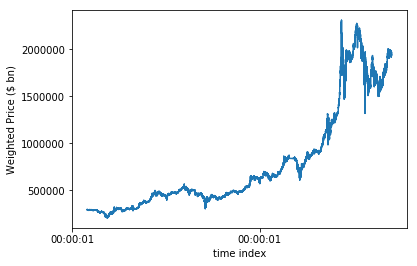

In [28]:
plt.plot(bitcoin_market['Timestamp'],bitcoin_market['Weighted_Price'])
plt.xlabel('time index')
plt.ylabel('Weighted Price ($ bn)')
plt.show

In [31]:
# normalise the data:
values = bitcoin_market['Weighted_Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

#splitting the data: 80% for trainig and 20% for testing:
train_size= int(len(scaled_values)*0.8)
test_size= len(scaled_values)-train_size
train,test= scaled_values[0:train_size,:], scaled_values[train_size:len(scaled_values),:]
print(len(train), len(test))

213420 53355


In [33]:
# Creating testing and training data:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
look_back = 1
X_Train, Y_Train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# need to reshape the training model for it to be loaded into Keras as:
#[reshape into 3 dimensions, [batch_size, timesteps, input_dim]
X_Train = np.reshape(X_Train, (X_Train.shape[0], 1, X_Train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


213419
53354


In [42]:
# defining the keras model:
def LSTM_model(inputs, output_size, units, activ_func = "linear",
                dropout =0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(units, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

LSTM_units=100
output_size=1

bitcoin_model= LSTM_model(X_Train,output_size,LSTM_units,)

# training Keras model:

%time history= bitcoin_model.fit(X_Train,Y_Train, epochs=150, batch_size=100, validation_data= (x_test,y_test), verbose=1, shuffle=False)


Train on 213419 samples, validate on 53354 samples
Epoch 1/150
213419/213419 [==============================] - 26s 121us/step - loss: 0.0063 - val_loss: 0.1800
Epoch 2/150
213419/213419 [==============================] - 20s 95us/step - loss: 0.0097 - val_loss: 0.1487
Epoch 3/150
213419/213419 [==============================] - 20s 94us/step - loss: 0.0093 - val_loss: 0.1300
Epoch 4/150
213419/213419 [==============================] - 21s 100us/step - loss: 0.0078 - val_loss: 0.1026
Epoch 5/150
213419/213419 [==============================] - 21s 97us/step - loss: 0.0061 - val_loss: 0.0824
Epoch 6/150
213419/213419 [==============================] - 18s 86us/step - loss: 0.0052 - val_loss: 0.0694
Epoch 7/150
213419/213419 [==============================] - 17s 82us/step - loss: 0.0048 - val_loss: 0.0634
Epoch 8/150
213419/213419 [==============================] - 20s 94us/step - loss: 0.0047 - val_loss: 0.0667
Epoch 9/150
213419/213419 [==============================] - 20s 94us/step 

Epoch 75/150
213419/213419 [==============================] - 32s 150us/step - loss: 0.0042 - val_loss: 0.0604
Epoch 76/150
213419/213419 [==============================] - 24s 114us/step - loss: 0.0041 - val_loss: 0.0653
Epoch 77/150
213419/213419 [==============================] - 33s 153us/step - loss: 0.0042 - val_loss: 0.0608
Epoch 78/150
213419/213419 [==============================] - 29s 138us/step - loss: 0.0042 - val_loss: 0.0599
Epoch 79/150
213419/213419 [==============================] - 35s 163us/step - loss: 0.0042 - val_loss: 0.0536
Epoch 80/150
213419/213419 [==============================] - 29s 135us/step - loss: 0.0042 - val_loss: 0.0590
Epoch 81/150
213419/213419 [==============================] - 30s 141us/step - loss: 0.0042 - val_loss: 0.0580
Epoch 82/150
213419/213419 [==============================] - 31s 144us/step - loss: 0.0042 - val_loss: 0.0614
Epoch 83/150
213419/213419 [==============================] - 30s 139us/step - loss: 0.0042 - val_loss: 0.0646
E

dict_keys(['val_loss', 'loss'])


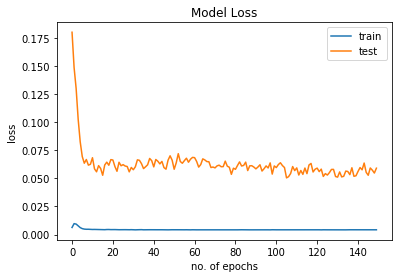

In [45]:
print(history.history.keys())

# now visualise history for loss:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper right')
plt.show()

# Note: need to find out how I can output the accuracy

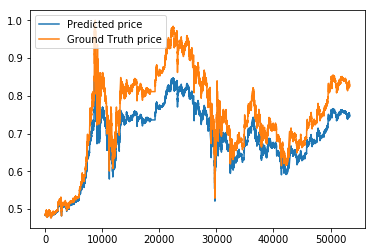

In [47]:
# Now let's predict:
predicted_price= bitcoin_model.predict(x_test)
plt.plot(predicted_price)
plt.plot(y_test)
plt.legend(['Predicted price','Ground Truth price'],loc='upper left')